In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

In [23]:
df = pd.read_csv('../../Datasets/PERMIT.csv', index_col='observation_date', parse_dates=True) #Dataset file

df.PERMIT = pd.to_numeric(df.PERMIT)
df.head()

,PERMIT
observation_date,
1960-01-01,1092
1960-02-01,1088
1960-03-01,955
1960-04-01,1016
1960-05-01,1052


In [24]:
recession = pd.read_csv('../../Datasets/Recession.csv')
recession.head()

,DATE,JHDUSRGDPBR
0,1967-10-01,0.0
1,1968-01-01,0.0
2,1968-04-01,0.0
3,1968-07-01,0.0
4,1968-10-01,0.0


In [25]:
recession.columns = ['DATE', 'recession']
recession['DATE'] = pd.to_datetime(recession['DATE'])
start = []
end = []
for i, date in enumerate(recession.DATE):
  if i == 0 or i==len(recession.DATE)-1:
    continue
  if (recession.recession[i-1] == 0) & (recession.recession[i] == 1):
    start.append(date)
  elif (recession.recession[i] == 1) & (recession.recession[i+1] == 0):
    end.append(date)
print(start)
print(end)
Reces = pd.DataFrame()
Reces['start'] = start
Reces['end'] = end


[Timestamp('1969-04-01 00:00:00'), Timestamp('1973-10-01 00:00:00'), Timestamp('1979-04-01 00:00:00'), Timestamp('1981-04-01 00:00:00'), Timestamp('1989-10-01 00:00:00'), Timestamp('2001-01-01 00:00:00'), Timestamp('2007-10-01 00:00:00'), Timestamp('2020-01-01 00:00:00')]
[Timestamp('1970-10-01 00:00:00'), Timestamp('1975-01-01 00:00:00'), Timestamp('1980-04-01 00:00:00'), Timestamp('1982-04-01 00:00:00'), Timestamp('1991-01-01 00:00:00'), Timestamp('2001-07-01 00:00:00'), Timestamp('2009-04-01 00:00:00'), Timestamp('2020-04-01 00:00:00')]


In [26]:
df.head()

,PERMIT
observation_date,
1960-01-01,1092
1960-02-01,1088
1960-03-01,955
1960-04-01,1016
1960-05-01,1052


/var/folders/j1/xhx1rv6n1g53g2tjrfmrknz00000gn/T/ipykernel_24987/1996458875.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MIN_1Y'][i] = np.nan
/var/folders/j1/xhx1rv6n1g53g2tjrfmrknz00000gn/T/ipykernel_24987/1996458875.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MIN_1Y'][i] = take.max()


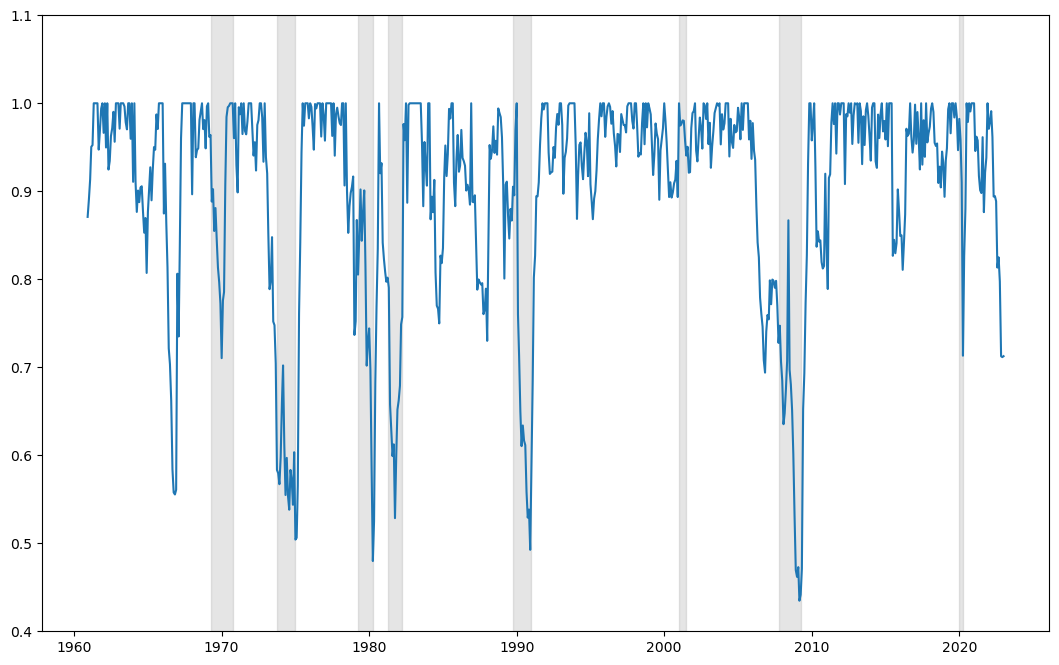

In [27]:
# Define Percent Change
df['MIN_1Y'] = np.nan
for i in range(len(df)):
  if i >= 11:
    arr = np.array(df['PERMIT'])
    indices = [i-k for k in range(12)]
    take = np.take(arr, indices)
    df['MIN_1Y'][i] = take.max()
  else:
    df['MIN_1Y'][i] = np.nan

df['CHG'] = (df['PERMIT'])/df['MIN_1Y']
#--------------------------------------------------#
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(df.index, df['CHG'])
for i in range(len(Reces['start'])):
  ax.axvspan(start[i], end[i], color='grey', alpha=0.2)
#ax.axhline(0.81, color='red')
plt.ylim(0.4,1.1)
plt.show()

In [28]:
def calc_TP_FP_rate(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    return tpr, fpr

In [29]:
tot = []

for m in range(0,13): # 12 months
  dfi = df.copy()
  dfi.index = dfi.index + dt.timedelta(days=m*30)

  dfi['MIN_1Y'] = np.nan
  for i in range(len(dfi)):
    if i >= 11:
      arr = np.array(dfi['PERMIT'])
      indices = [i-k for k in range(12)]
      take = np.take(arr, indices)
      dfi['MIN_1Y'][i] = take.max()
    else:
      dfi['MIN_1Y'][i] = np.nan
 

  li = []
  for i in range(2,8):
    li.append(dfi.reset_index()['observation_date'].apply(lambda x: int((x > Reces.loc[i]['start'])&(x < Reces.loc[i]['end']))))
  test = reduce(lambda x,y:x+y, li)
  dfi['recession'] = test.values.copy()
  
#Containers for true positive / false positive rates
  tp_rates = []
  fp_rates = []

  threshold = np.linspace(0.6,1.0,num=25)

  # Find true positive / false positive rate for each threshold
  for t in threshold:
      
      dfi['predict'] = dfi['CHG'].apply(lambda x: int(x<t))
      tp_rate, fp_rate = calc_TP_FP_rate(dfi['recession'], dfi['predict'])
          
      tp_rates.append(tp_rate)
      fp_rates.append(fp_rate)
  
  tot.append([fp_rates, tp_rates])

/var/folders/j1/xhx1rv6n1g53g2tjrfmrknz00000gn/T/ipykernel_24987/1093207050.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi['MIN_1Y'][i] = np.nan
/var/folders/j1/xhx1rv6n1g53g2tjrfmrknz00000gn/T/ipykernel_24987/1093207050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfi['MIN_1Y'][i] = take.max()
/var/folders/j1/xhx1rv6n1g53g2tjrfmrknz00000gn/T/ipykernel_24987/1093207050.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

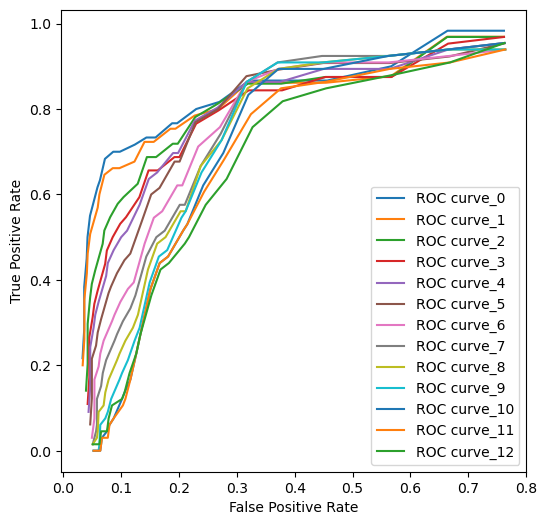

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(tot)):
  ax.plot(tot[i][0], tot[i][1], label=f'ROC curve_{i}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

auc score for 0 month(s) prediction 0.6159134385461501
auc score for 1 month(s) prediction 0.6044464206313918
auc score for 2 month(s) prediction 0.5911120129870129
auc score for 3 month(s) prediction 0.5771103896103895
auc score for 4 month(s) prediction 0.5795838266894707
auc score for 5 month(s) prediction 0.5740995998221432
auc score for 6 month(s) prediction 0.5570429329474192
auc score for 7 month(s) prediction 0.5499605315090119
auc score for 8 month(s) prediction 0.5395781256852168
auc score for 9 month(s) prediction 0.5340635004166119
auc score for 10 month(s) prediction 0.520479761434899
auc score for 11 month(s) prediction 0.5042867166600886
auc score for 12 month(s) prediction 0.49255580406086924


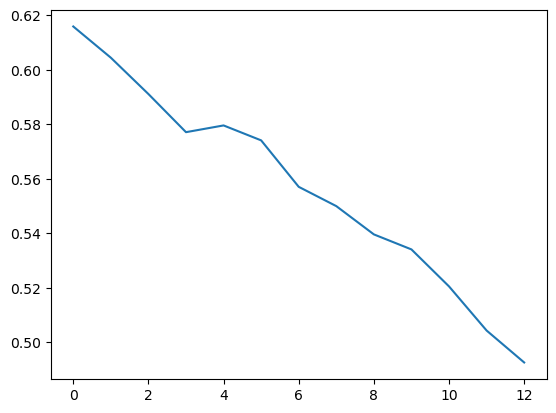

In [31]:
from sklearn.metrics import auc
auc_x = []
auc_y = []
for i in range(len(tot)):
  auc_x.append(i)
  auc_y.append(auc(tot[i][0], tot[i][1]))
  print(f'auc score for {i} month(s) prediction {auc_y[i]}')
plt.plot(auc_x, auc_y)

In [32]:
temp = pd.DataFrame()
temp['False negative'] = tot[1][0]
temp['True positive'] = tot[1][1]
temp

,False negative,True positive
0,0.033237,0.200000
1,0.036127,0.261538
2,0.036127,0.292308
3,0.036127,0.353846
4,0.040462,0.415385
5,0.041908,0.461538
6,0.046243,0.507692
7,0.059249,0.569231
8,0.062139,0.600000
9,0.070809,0.646154


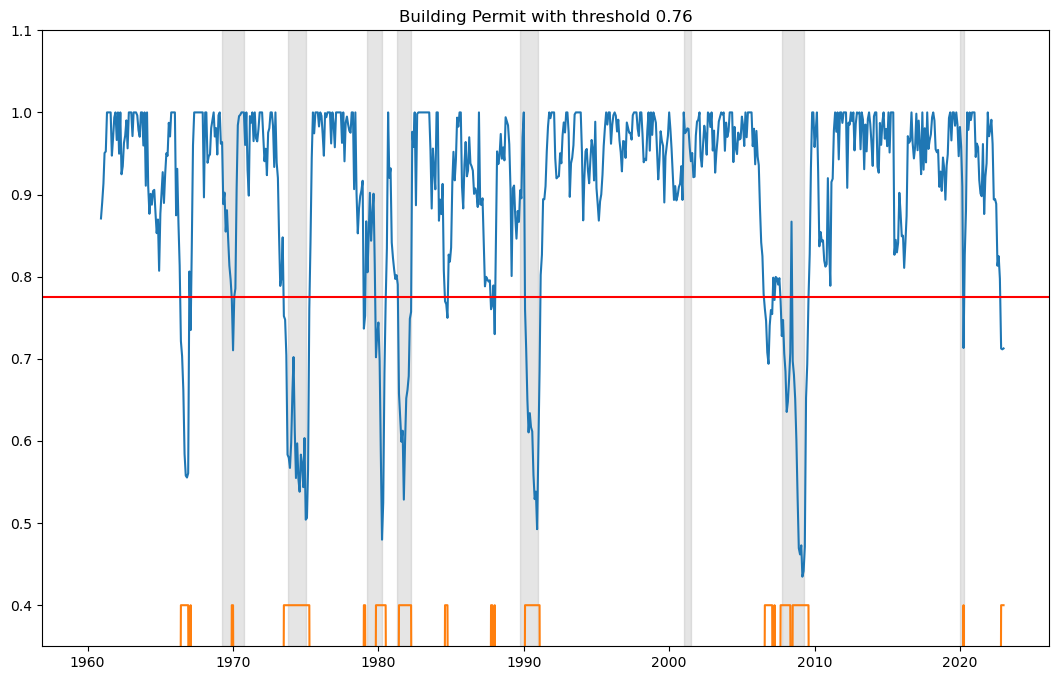

In [35]:
# choose
threshold = np.linspace(0.4,1.0,num=25)
final_thres = threshold[15]

df['predict'] = df['CHG'].apply(lambda x: int(x<final_thres))
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(df.index, df['CHG'])
ax.plot(df.index, df['predict']*0.4)
for i in range(len(Reces['start'])):
  ax.axvspan(start[i], end[i], color='grey', alpha=0.2)
ax.axhline(final_thres, color='red')
plt.ylim(0.35,1.1)
plt.title('Building Permit with threshold 0.76')
plt.show()


In [37]:
df.index.rename('DATE', inplace=True)
df['predict'].to_csv('prediction/Index4-prediction.csv')